Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

### Загрузка данных


In [ ]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image
# Для отрисовки графиков
import matplotlib.pyplot as plt
# Для генерации случайных чисел
import random
# Библиотека работы с массивами
import numpy as np
# Для работы с файлами
import os
# импортируем модуль для загрузки данных
import gdown
# для разделения выборок
from sklearn.model_selection import train_test_split
# для создания сети
from tensorflow.keras.models import Sequential
# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
# для работы с изображениями
from tensorflow.keras.preprocessing import image
# оптимизатор
from tensorflow.keras.optimizers import Adam
# модуль для отсчета времени
import time

In [3]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

['Входящий', 'Выходящий']

In [4]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [5]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['00635.jpg', '04195.jpg', '04285.jpg', '01588.jpg', '00726.jpg', '01001.jpg', '05405.jpg', '00839.jpg', '05914.jpg', '04503.jpg', '05310.jpg', '01690.jpg', '04768.jpg', '00747.jpg', '01045.jpg', '01439.jpg', '01528.jpg', '05991.jpg', '00388.jpg', '02773.jpg', '01630.jpg', '01020.jpg', '02384.jpg', '05644.jpg', '04721.jpg', '02208.jpg', '03121.jpg', '05475.jpg', '02631.jpg', '04452.jpg', '05010.jpg', '00024.jpg', '02584.jpg', '02243.jpg', '03483.jpg', '02952.jpg', '05184.jpg', '00773.jpg', '06280.jpg', '05679.jpg', '02122.jpg', '01183.jpg', '04718.jpg', '02835.jpg', '04955.jpg', '05912.jpg', '03684.jpg', '00108.jpg', '02086.jpg', '01395.jpg', '03064.jpg', '02246.jpg', '03550.jpg', '01450.jpg', '05532.jpg', '01550.jpg', '06398.jpg', '06417.jpg', '01703.jpg', '02114.jpg', '01862.jpg', '03755.jpg', '03810.jpg', '01507.jpg', '04083.jpg', '01780.jpg', '03737.jpg', '03015.jpg', '01767.jpg', '00845.jpg', '05628.jpg', '06283.jpg', '04752.jpg', '04991.jpg', '05655.jpg', '01133.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

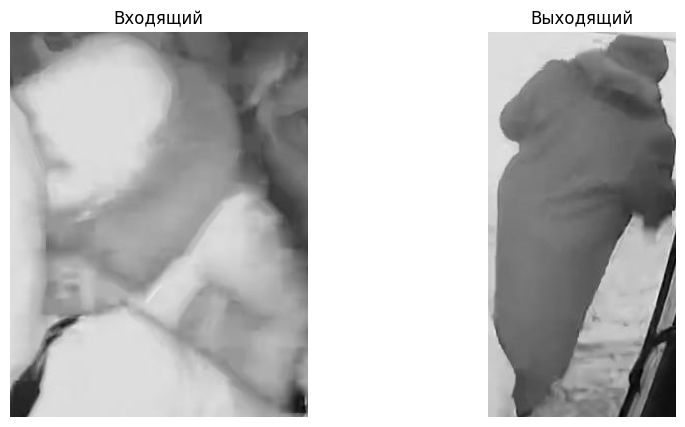

In [6]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [7]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


Found 7265 images belonging to 2 classes.
Found 1816 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 483s 2s/step - accuracy: 0.6586 - loss: 0.3211 - val_accuracy: 0.6580 - val_loss: 0.6633
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - accuracy: 0.7627 - loss: 0.1986 - val_accuracy: 0.7137 - val_loss: 0.5723
Epoch 3/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - accuracy: 0.7864 - loss: 0.1857 - val_accuracy: 0.7230 - val_loss: 0.7341
Epoch 4/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 495s 2s/step - accuracy: 0.8000 - loss: 0.1712 - val_accuracy: 0.7076 - val_loss: 0.6001
Epoch 5/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - accuracy: 0.8141 - loss: 0.1679 - val_accuracy: 0.6911 - val_loss: 0.6185
Epoch 6/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.8185 - loss: 0.1624 - val_accuracy: 0.7291 - val_loss: 0.6001
Epoch 7/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.8482 - loss: 0.1458 - val_accuracy: 0.5887 - val_loss: 0.7587
Epoch 8/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - accuracy: 0.8603 - loss: 0.1339 - val_accu

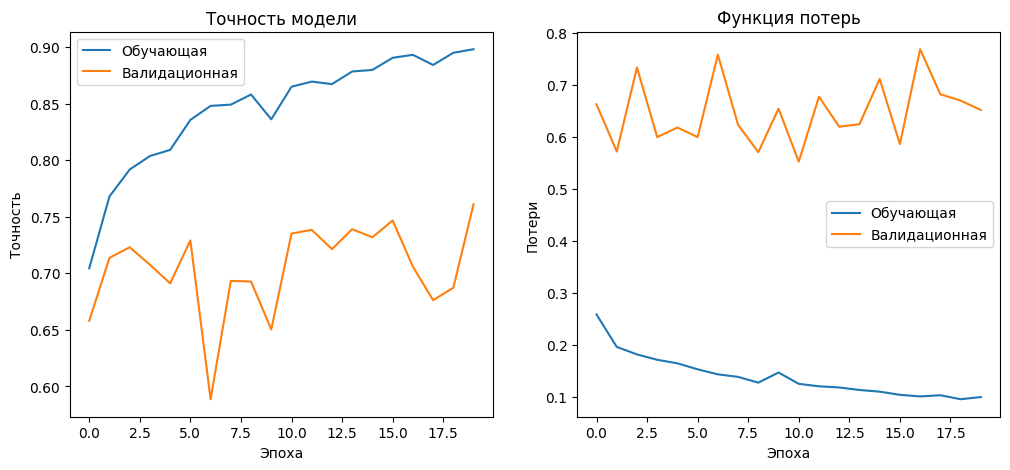

Found 9081 images belonging to 2 classes.
284/284 ━━━━━━━━━━━━━━━━━━━━ 129s 455ms/step - accuracy: 0.9459 - loss: 0.1732
Точность на тестовых данных: 90.27%


In [8]:
# ваше решение
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Параметры изображения
IMG_SIZE = 150
CHANNELS = 3

# Создание генератора данных с аугментацией
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Загрузка и подготовка данных
train_generator = train_datagen.flow_from_directory(
    IMAGE_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    IMAGE_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Расчет весов классов для устранения дисбаланса
class_weights = {
    0: len(os.listdir(f'{IMAGE_PATH}Выходящий')) / len(data_labels),
    1: len(os.listdir(f'{IMAGE_PATH}Входящий')) / len(data_labels)
}

# Создание модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Обучение модели
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights,
    verbose=1
)

# Визуализация результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Обучающая')
plt.plot(history.history['val_accuracy'], label='Валидационная')
plt.title('Точность модели')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Обучающая')
plt.plot(history.history['val_loss'], label='Валидационная')
plt.title('Функция потерь')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.legend()

plt.show()

# Проверка точности на тестовых данных
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    IMAGE_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print(f'Точность на тестовых данных: {accuracy*100:.2f}%')